<a href="https://colab.research.google.com/github/Eieiz007/Deep-learning/blob/main/Seq2Seq_Attention_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam , AdamW
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate
import matplotlib.pyplot as plt


# Create data

In [15]:
date_range = pd.date_range(start="2023-01-01", end="2025-12-31", freq="D") #วันที่ 2 ปี

days = np.arange(len(date_range))
temperature = 25 + 5 * np.sin(2 * np.pi * days / 365) + np.random.normal(0, 2, len(days))
humidity = 60 + 10 * np.cos(2 * np.pi * days / 365) + np.random.normal(0, 5, len(days))
np.random.seed(42)

df = pd.DataFrame({
    "date": date_range,
    "temperature": temperature,
    "humidity": humidity
})

# แสดงตัวอย่างข้อมูล
df.head(10)


,date,temperature,humidity
0,2023-01-01,25.993428,70.393176
1,2023-01-02,24.809538,60.007515
2,2023-01-03,26.467485,74.575712
3,2023-01-04,28.304158,71.719111
4,2023-01-05,24.875705,74.966354
5,2023-01-06,24.961550,55.481705
6,2023-01-07,28.673934,80.388582
7,2023-01-08,27.135910,69.229539
8,2023-01-09,24.747445,75.446239
9,2023-01-10,26.856664,64.680697


array([[<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'humidity'}>]], dtype=object)

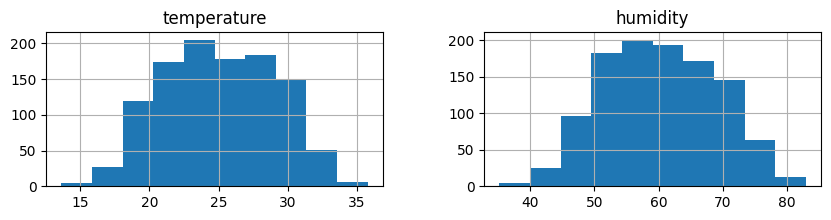

In [16]:
df.iloc[:,1:].hist(figsize=(10,2))

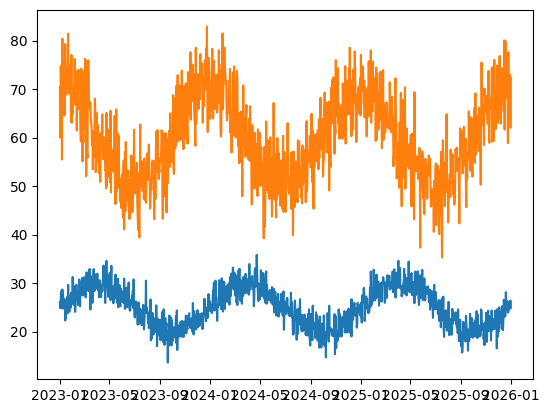

In [17]:
plt.plot(df['date'], df['temperature'])
plt.plot(df['date'], df['humidity'])

# Data prepartation for train model

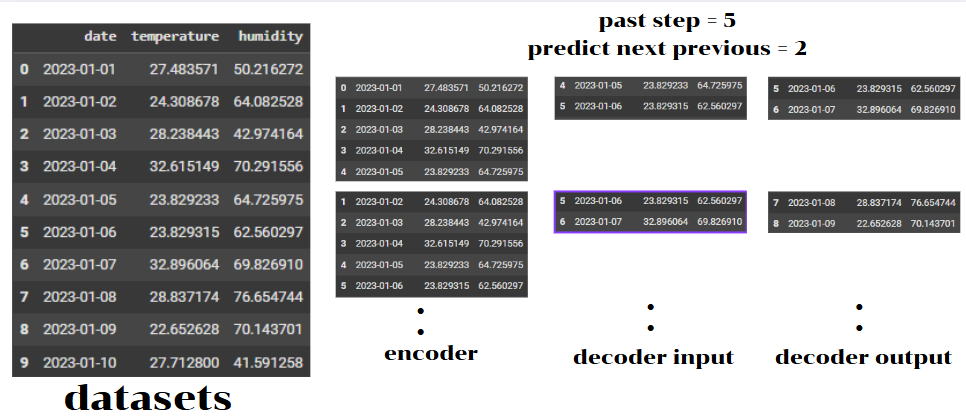

In [18]:
len(df)

1096

In [19]:
encoder_timesteps = 5  # ใช้ข้อมูลย้อนหลัง 5 วัน
decoder_timesteps = 2    # ทำนายอนาคต 2 วัน

X_encoder, Y_decoder_input, Y_decoder_output = [], [], []

for i in range(len(df) - encoder_timesteps - decoder_timesteps):
    # Encoder input (5 วันก่อนหน้า)          # 0 1 2 3 4
    X_encoder.append(df.iloc[i : i + encoder_timesteps][["temperature", "humidity"]].values)

    # Decoder input (ใช้ค่าจริงของ 2 วันถัดไป) # 4 5
    Y_decoder_input.append(df.iloc[i + encoder_timesteps-1 : (i + encoder_timesteps-1) + decoder_timesteps][["temperature", "humidity"]].values)

    # Decoder output (ค่าที่ต้องทำนาย)       # 5 6
    Y_decoder_output.append(df.iloc[i + encoder_timesteps: i + encoder_timesteps + decoder_timesteps][["temperature", "humidity"]].values)

# แปลงเป็น NumPy array
X_encoder = np.array(X_encoder)
Y_decoder_input = np.array(Y_decoder_input)
Y_decoder_output = np.array(Y_decoder_output)

# ตรวจสอบขนาดของข้อมูล
X_encoder.shape, Y_decoder_input.shape, Y_decoder_output.shape


((1089, 5, 2), (1089, 2, 2), (1089, 2, 2))

In [20]:
X_encoder[:3] , '**********************************************', Y_decoder_input[:1], '**********************************************', Y_decoder_output[:1]

(array([[[25.99342831, 70.39317595],
         [24.80953818, 60.00751497],
         [26.46748513, 74.57571238],
         [28.30415805, 71.71911054],
         [24.87570538, 74.9663536 ]],
 
        [[24.80953818, 60.00751497],
         [26.46748513, 74.57571238],
         [28.30415805, 71.71911054],
         [24.87570538, 74.9663536 ],
         [24.96155008, 55.48170486]],
 
        [[26.46748513, 74.57571238],
         [28.30415805, 71.71911054],
         [24.87570538, 74.9663536 ],
         [24.96155008, 55.48170486],
         [28.67393412, 80.38858172]]]),
 '**********************************************',
 array([[[24.87570538, 74.9663536 ],
         [24.96155008, 55.48170486]]]),
 '**********************************************',
 array([[[24.96155008, 55.48170486],
         [28.67393412, 80.38858172]]]))

# Data splitting and Normalization

In [21]:
X_train_enc, X_temp_enc    , Y_train_dec_in, Y_temp_dec_in ,     Y_train_dec_out, Y_temp_dec_out = train_test_split(
    X_encoder, Y_decoder_input, Y_decoder_output
    , test_size=0.3, shuffle=False
)

X_val_enc, X_test_enc,       Y_val_dec_in, Y_test_dec_in,       Y_val_dec_out, Y_test_dec_out = train_test_split(
    X_temp_enc, Y_temp_dec_in, Y_temp_dec_out
    , test_size=0.5, shuffle=False
)

print("Encoder Input Shapes:")
print(f"X_train_enc: {X_train_enc.shape}")
print(f"X_val_enc: {X_val_enc.shape}")
print(f"X_test_enc: {X_test_enc.shape}")

print("\nDecoder Input Shapes:")
print(f"Y_train_dec_in: {Y_train_dec_in.shape}")
print(f"Y_val_dec_in: {Y_val_dec_in.shape}")
print(f"Y_test_dec_in: {Y_test_dec_in.shape}")

print("\nDecoder Output Shapes:")
print(f"Y_train_dec_out: {Y_train_dec_out.shape}")
print(f"Y_val_dec_out: {Y_val_dec_out.shape}")
print(f"Y_test_dec_out: {Y_test_dec_out.shape}")


Encoder Input Shapes:
X_train_enc: (762, 5, 2)
X_val_enc: (163, 5, 2)
X_test_enc: (164, 5, 2)

Decoder Input Shapes:
Y_train_dec_in: (762, 2, 2)
Y_val_dec_in: (163, 2, 2)
Y_test_dec_in: (164, 2, 2)

Decoder Output Shapes:
Y_train_dec_out: (762, 2, 2)
Y_val_dec_out: (163, 2, 2)
Y_test_dec_out: (164, 2, 2)


In [22]:
scaler_enc = MinMaxScaler()
scaler_dec = MinMaxScaler()

X_train_enc_scaled = scaler_enc.fit_transform(X_train_enc.reshape(-1, X_train_enc.shape[-1])).reshape(X_train_enc.shape)
X_val_enc_scaled = scaler_enc.transform(X_val_enc.reshape(-1, X_val_enc.shape[-1])).reshape(X_val_enc.shape)
X_test_enc_scaled = scaler_enc.transform(X_test_enc.reshape(-1, X_test_enc.shape[-1])).reshape(X_test_enc.shape)

Y_train_dec_in_scaled = scaler_dec.fit_transform(Y_train_dec_in.reshape(-1, Y_train_dec_in.shape[-1])).reshape(Y_train_dec_in.shape)
Y_val_dec_in_scaled = scaler_dec.transform(Y_val_dec_in.reshape(-1, Y_val_dec_in.shape[-1])).reshape(Y_val_dec_in.shape)
Y_test_dec_in_scaled = scaler_dec.transform(Y_test_dec_in.reshape(-1, Y_test_dec_in.shape[-1])).reshape(Y_test_dec_in.shape)

Y_train_dec_out_scaled = scaler_dec.transform(Y_train_dec_out.reshape(-1, Y_train_dec_out.shape[-1])).reshape(Y_train_dec_out.shape)
Y_val_dec_out_scaled = scaler_dec.transform(Y_val_dec_out.reshape(-1, Y_val_dec_out.shape[-1])).reshape(Y_val_dec_out.shape)
Y_test_dec_out_scaled = scaler_dec.transform(Y_test_dec_out.reshape(-1, Y_test_dec_out.shape[-1])).reshape(Y_test_dec_out.shape)

print("After MinMax Scaling:")
print(f"X_train_enc_scaled: {X_train_enc_scaled.shape}")
print(f"X_val_enc_scaled: {X_val_enc_scaled.shape}")
print(f"X_test_enc_scaled: {X_test_enc_scaled.shape}")
print(f"Y_train_dec_in_scaled: {Y_train_dec_in_scaled.shape}")
print(f"Y_val_dec_in_scaled: {Y_val_dec_in_scaled.shape}")
print(f"Y_test_dec_in_scaled: {Y_test_dec_in_scaled.shape}")
print(f"Y_train_dec_out_scaled: {Y_train_dec_out_scaled.shape}")
print(f"Y_val_dec_out_scaled: {Y_val_dec_out_scaled.shape}")
print(f"Y_test_dec_out_scaled: {Y_test_dec_out_scaled.shape}")


After MinMax Scaling:
X_train_enc_scaled: (762, 5, 2)
X_val_enc_scaled: (163, 5, 2)
X_test_enc_scaled: (164, 5, 2)
Y_train_dec_in_scaled: (762, 2, 2)
Y_val_dec_in_scaled: (163, 2, 2)
Y_test_dec_in_scaled: (164, 2, 2)
Y_train_dec_out_scaled: (762, 2, 2)
Y_val_dec_out_scaled: (163, 2, 2)
Y_test_dec_out_scaled: (164, 2, 2)


# Train model

In [23]:
# Config
encoder_timesteps = 5   # จำนวนวันย้อนหลัง
decoder_timesteps = 2   # จำนวนวันที่ต้องการทำนาย
hidden_dim = 64         # ขนาดของ Hidden State
n_features = 2          # Temperature, Humidity

# ===== Encoder =====
encoder_inputs = Input(shape=(encoder_timesteps, n_features))
encoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# ===== Decoder =====
decoder_inputs = Input(shape=(decoder_timesteps, n_features))
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# ===== Attention Layer =====
attention = Dot(axes=(2, 2))([decoder_outputs, encoder_outputs])  # Dot Product Attention
attention_score = Activation('softmax')(attention)  # Softmax เพื่อได้ Weight
context = Dot(axes=(2, 1))([attention_score, encoder_outputs])  # คูณ Score กับ Encoder Output
decoder_combined = Concatenate()([context, decoder_outputs])  # รวม Context + Decoder Output

# ===== Fully Connected Layer =====
decoder_dense = Dense(n_features, activation="linear")(decoder_combined)


# ===== Seq2Seq Model =====
model = Model([encoder_inputs, decoder_inputs], decoder_dense)
model.compile(optimizer=AdamW(learning_rate=0.00001), loss="mse")
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 5, 2)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 2, 2)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 5, 64), (None, │         17,152 │ input_layer_4[0][0]    │
│                           │ 64), (None, 64)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ [(None, 2, 64), (None, │         17,152 │ input_layer_5[0][0],   │
│                           │ 64), (None, 64)]       │                │ lstm_4[0][1],          │
│                           │                        │                │ lstm_4[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_4 (Dot)               │ (None, 2, 5)           │              0 │ lstm_5[0][0],          │
│                           │                        │                │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 2, 5)           │              0 │ dot_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_5 (Dot)               │ (None, 2, 64)          │              0 │ activation_2[0][0],    │
│                           │                        │                │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 2, 128)         │              0 │ dot_5[0][0],           │
│ (Concatenate)             │                        │                │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2, 2)           │            258 │ concatenate_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,562 (135.01 KB)

 Trainable params: 34,562 (135.01 KB)

 Non-trainable params: 0 (0.00 B)

LSTM ออกมา 3 อย่าง output , h , c มันก็เลยเป็น shape 3 ตัว

In [24]:
history = model.fit(
    [X_train_enc_scaled, Y_train_dec_in_scaled], Y_train_dec_out_scaled,
    validation_data=([X_val_enc_scaled, Y_val_dec_in_scaled], Y_val_dec_out_scaled),
    epochs=100,
    batch_size=64
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.3094 - val_loss: 0.3514
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3063 - val_loss: 0.3480
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3068 - val_loss: 0.3446
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3080 - val_loss: 0.3413
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3031 - val_loss: 0.3380
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2952 - val_loss: 0.3347
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2925 - val_loss: 0.3315
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2952 - val_loss: 0.3282
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2862 - val_loss: 0.3250
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2842 - val_loss: 0.3218
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2890 - val_loss: 0.3186
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

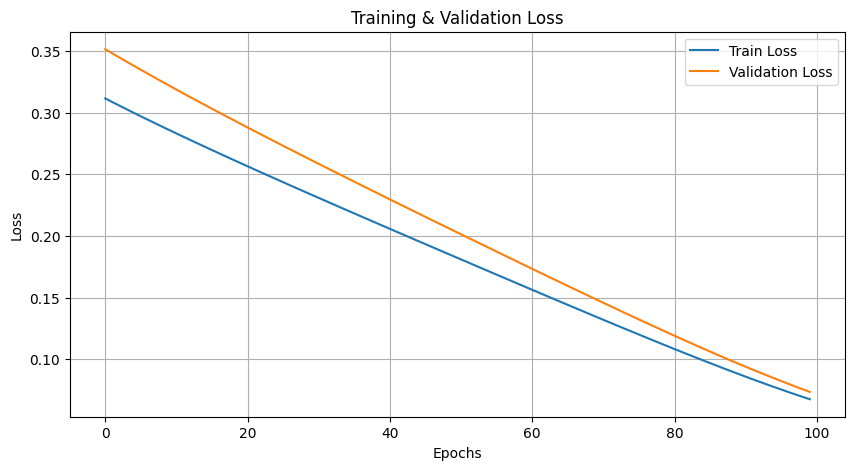

In [32]:

# ===== Plot กราฟ Loss =====
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()


# Test

In [33]:
Y_pred_test_scaled = model.predict([X_test_enc_scaled, Y_test_dec_in_scaled])
print(f"Prediction Shape: {Y_pred_test_scaled.shape}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Prediction Shape: (164, 2, 2)


In [34]:
# แปลงค่ากลับเป็นค่าเดิม
Y_pred_test = scaler_dec.inverse_transform(Y_pred_test_scaled.reshape(-1, Y_pred_test_scaled.shape[-1])).reshape(Y_pred_test_scaled.shape)

# แปลงค่าจริงกลับเป็นค่าเดิม
Y_test_dec_out_original = scaler_dec.inverse_transform(Y_test_dec_out_scaled.reshape(-1, Y_test_dec_out_scaled.shape[-1])).reshape(Y_test_dec_out_scaled.shape)
Y_test_dec_out_original.shape

(164, 2, 2)

In [35]:
Y_test_dec_out_original[: , 0 , 0]

array([22.40603685, 27.19677893, 20.45692979, 18.87432652, 24.07146025,
       22.10735173, 20.98958298, 24.3699331 , 23.36259973, 21.66924882,
       20.15985774, 24.38911712, 23.86903882, 22.29543921, 26.11296204,
       20.20618023, 19.22274747, 20.81823755, 22.03996663, 22.54775264,
       21.50940757, 22.62768779, 19.35310708, 24.67725564, 21.55991586,
       23.89427234, 22.28158365, 22.4471003 , 22.61161651, 22.30703255,
       22.63765775, 23.95219501, 21.6297082 , 22.59856445, 20.9461084 ,
       23.95198516, 19.66630108, 24.56948113, 20.83699384, 18.0066788 ,
       21.07658143, 19.4116514 , 22.40967625, 19.3790414 , 19.74910154,
       16.82085752, 19.65510075, 15.67304489, 17.31541534, 21.96780616,
       21.98368219, 21.22946151, 18.41242806, 20.22017056, 20.2789892 ,
       17.94146272, 23.23839162, 21.9611355 , 19.74071891, 20.21408276,
       20.55617463, 16.03647751, 19.60757678, 18.72139874, 18.06701923,
       19.49441146, 23.63980273, 21.31540148, 18.88211546, 21.16

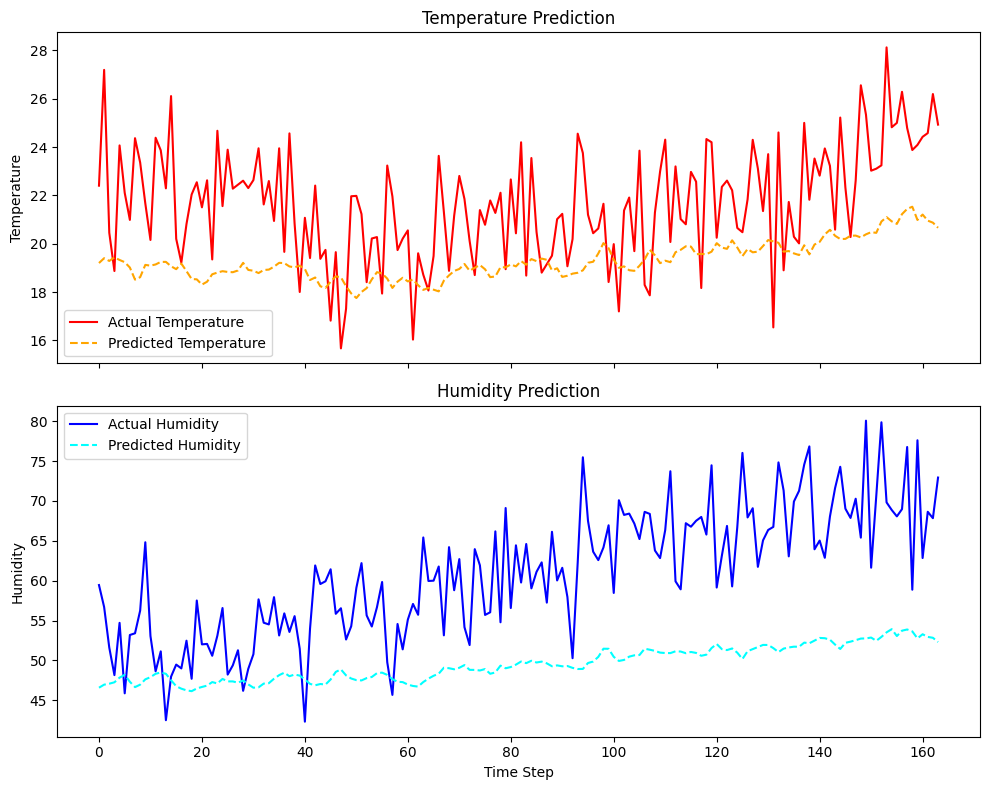

In [36]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=True)

axes[0].plot(Y_test_dec_out_original[:, 0, 0], label="Actual Temperature", color="red")
axes[0].plot(Y_pred_test[:, 0, 0], label="Predicted Temperature", linestyle="dashed", color="orange")
axes[0].set_ylabel("Temperature")
axes[0].set_title("Temperature Prediction")
axes[0].legend()

axes[1].plot(Y_test_dec_out_original[:, 0, 1], label="Actual Humidity", color="blue")
axes[1].plot(Y_pred_test[:, 0, 1], label="Predicted Humidity", linestyle="dashed", color="cyan")
axes[1].set_ylabel("Humidity")
axes[1].set_title("Humidity Prediction")
axes[1].legend()

axes[1].set_xlabel("Time Step")

plt.tight_layout()
plt.show()


In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse_temp_scaled = mean_squared_error(Y_test_dec_out_scaled[:, :, 0], Y_pred_test_scaled[:, :, 0])
rmse_temp_scaled = np.sqrt(mse_temp_scaled)
mae_temp_scaled = mean_absolute_error(Y_test_dec_out_scaled[:, :, 0], Y_pred_test_scaled[:, :, 0])

mse_humid_scaled = mean_squared_error(Y_test_dec_out_scaled[:, :, 1], Y_pred_test_scaled[:, :, 1])
rmse_humid_scaled = np.sqrt(mse_humid_scaled)
mae_humid_scaled = mean_absolute_error(Y_test_dec_out_scaled[:, :, 1], Y_pred_test_scaled[:, :, 1])

print("=== Test Score (Before Inverse Transform) ===")
print(f"Temperature - MSE: {mse_temp_scaled:.6f}, RMSE: {rmse_temp_scaled:.6f}, MAE: {mae_temp_scaled:.6f}")
print(f"Humidity - MSE: {mse_humid_scaled:.6f}, RMSE: {rmse_humid_scaled:.6f}, MAE: {mae_humid_scaled:.6f}")

=== Test Score (Before Inverse Transform) ===
Temperature - MSE: 0.018686, RMSE: 0.136698, MAE: 0.114598
Humidity - MSE: 0.082732, RMSE: 0.287633, MAE: 0.250272


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse_temp = mean_squared_error(Y_test_dec_out_original[:, 0, 0], Y_pred_test[:, 0, 0])
rmse_temp = np.sqrt(mse_temp)
mae_temp = mean_absolute_error(Y_test_dec_out_original[:, 0, 0], Y_pred_test[:, 0, 0])

mse_humid = mean_squared_error(Y_test_dec_out_original[:, 0, 1], Y_pred_test[:, 0, 1])
rmse_humid = np.sqrt(mse_humid)
mae_humid = mean_absolute_error(Y_test_dec_out_original[:, 0, 1], Y_pred_test[:, 0, 1])

print("=== Test Score ===")
print(f"Temperature - MSE: {mse_temp:.4f}, RMSE: {rmse_temp:.4f}, MAE: {mae_temp:.4f}")
print(f"Humidity - MSE: {mse_humid:.4f}, RMSE: {rmse_humid:.4f}, MAE: {mae_humid:.4f}")

=== Test Score ===
Temperature - MSE: 9.9735, RMSE: 3.1581, MAE: 2.6742
Humidity - MSE: 172.7586, RMSE: 13.1438, MAE: 11.5509
